In [1]:
import numpy as np
import pandas as pd

In [3]:
from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Neural Network
from sklearn.neural_network import MLPClassifier
#from sklearn.grid_search import RandomizedSearchCV

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Naive bayes
from sklearn.naive_bayes import GaussianNB 

#Stacking
#from mlxtend.classifier import StackingClassifier


In [4]:
train_df = pd.read_csv('survey.csv')#load data

In [5]:
#omit useless data
train_df = train_df.drop(['comments'], axis= 1)
train_df = train_df.drop(['state'], axis= 1)
train_df = train_df.drop(['Timestamp'], axis= 1)

print(train_df.isnull().sum().max())#show the quantity of "null"
train_df.head(5)#show brief data

264


,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [6]:
defaultInt = 0
defaultString = 'NaN' #for future converge

intFeatures = ['Age'] #for future converge
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help'] #for future converge
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head(5)   

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [7]:
gender = train_df['Gender'].str.lower()#slower gender

#Select unique elements
gender = train_df['Gender'].unique()

male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():
    #replace the strange data
    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

In [8]:
#delete strange data
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]
#show data categories
print(train_df['Gender'].unique())

['female' 'male' 'trans']


In [9]:
#complete missing age with mean
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)
# Fill with media() values < 18 and > 120
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>120] = train_df['Age'].median()
train_df['Age'] = s

#Ranges of Age
train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

In [10]:
#change nan to No
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


In [11]:
train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


In [12]:
from sklearn import preprocessing

#Encoding data
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

#Get rid of 'Country'
train_df = train_df.drop(['Country'], axis= 1)
train_df.head()

label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


In [13]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                           Total  Percent
age_range                      0      0.0
obs_consequence                0      0.0
Gender                         0      0.0
self_employed                  0      0.0
family_history                 0      0.0
treatment                      0      0.0
work_interfere                 0      0.0
no_employees                   0      0.0
remote_work                    0      0.0
tech_company                   0      0.0
benefits                       0      0.0
care_options                   0      0.0
wellness_program               0      0.0
seek_help                      0      0.0
anonymity                      0      0.0
leave                          0      0.0
mental_health_consequence      0      0.0
phys_health_consequence        0      0.0
coworkers                      0      0.0
supervisor                     0      0.0
mental_health_interview        0      0.0
phys_health_interview          0      0.0
mental_vs_physical             0  

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<Figure size 1200x900 with 2 Axes>

<Figure size 640x480 with 2 Axes>

Text(0.5, 0, 'Age')

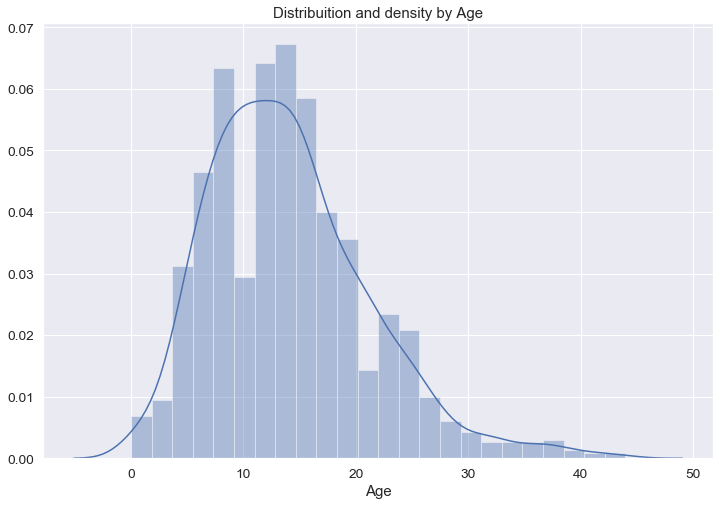

In [15]:
# Distribiution and density by Age
plt.figure(figsize=(12,8))
sns.distplot(train_df["Age"], bins=24)
plt.title("Distribuition and density by Age")
plt.xlabel("Age")

E:\anaconda\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


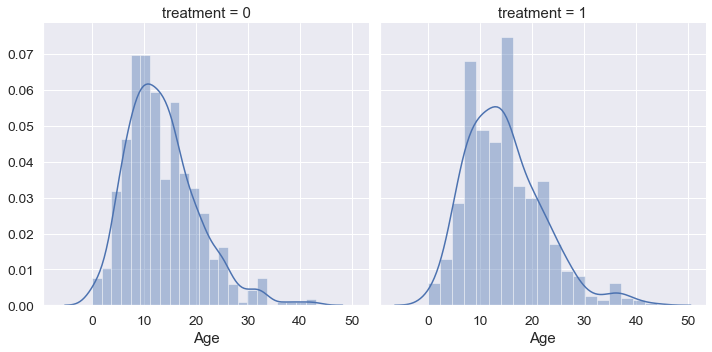

In [16]:
# Separate by treatment or not

g = sns.FacetGrid(train_df, col='treatment', size=5)
g = g.map(sns.distplot, "Age")

Text(0.5, 1.0, 'Total Distribuition by treated or not')

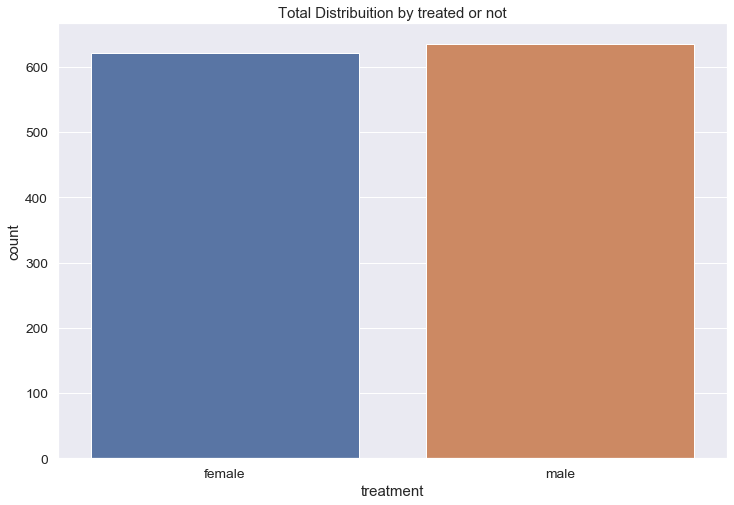

In [17]:
plt.figure(figsize=(12,8))
labels = labelDict['label_Gender']
g = sns.countplot(x="treatment", data=train_df)
g.set_xticklabels(labels)

plt.title('Total Distribuition by treated or not')

E:\anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
E:\anaconda\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


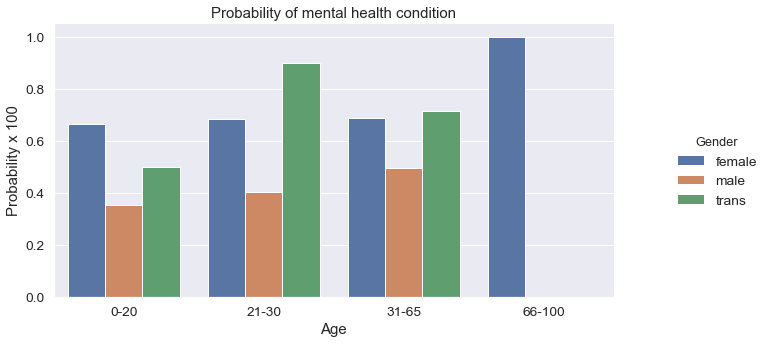

In [18]:
#Draw a nested barplot to show probabilities for class and sex
o = labelDict['label_age_range']

g = sns.factorplot(x="age_range", y="treatment", hue="Gender", data=train_df, kind="bar",  ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')
# replace legend labels

new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

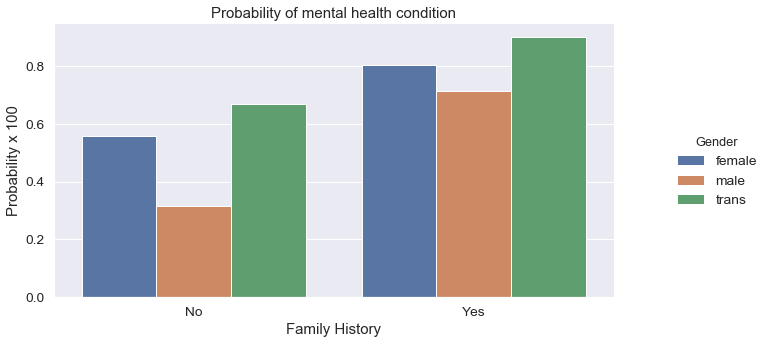

In [19]:
#Barplot to show probabilities for family history
o = labelDict['label_family_history']
g = sns.factorplot(x="family_history", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

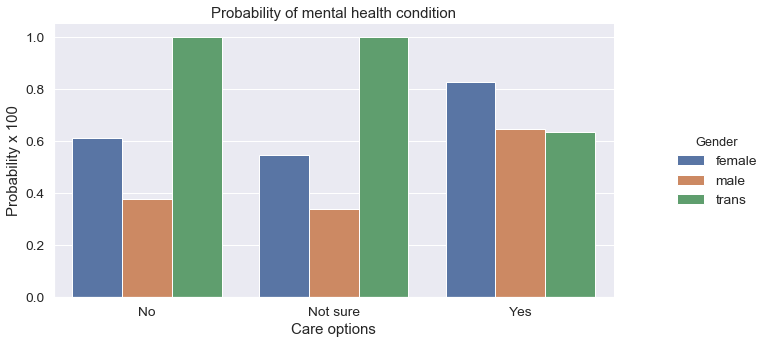

In [20]:
#Barplot to show probabilities for care options
o = labelDict['label_care_options']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

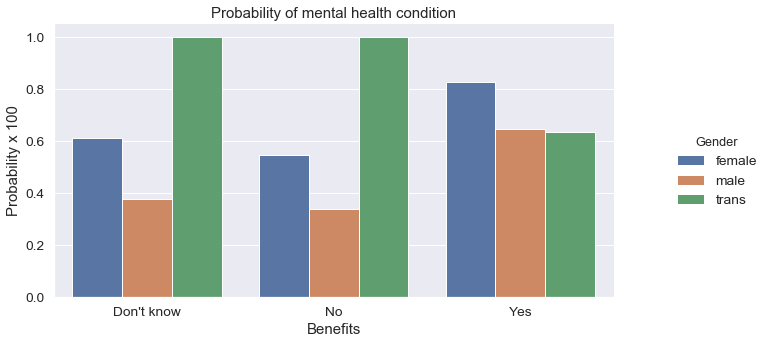

In [21]:
#Barplot to show probabilities for benefits
o = labelDict['label_benefits']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

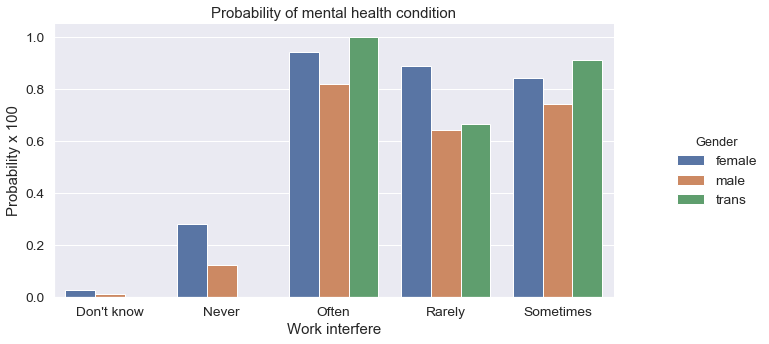

In [22]:
#Barplot to show probabilities for work interfere
o = labelDict['label_work_interfere']
g = sns.factorplot(x="work_interfere", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work interfere')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

In [23]:
#Features Scaling We're going to scale age, because is extremely different from the othere ones.
# Scaling Age
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df[['Age']])
train_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


In [24]:
# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

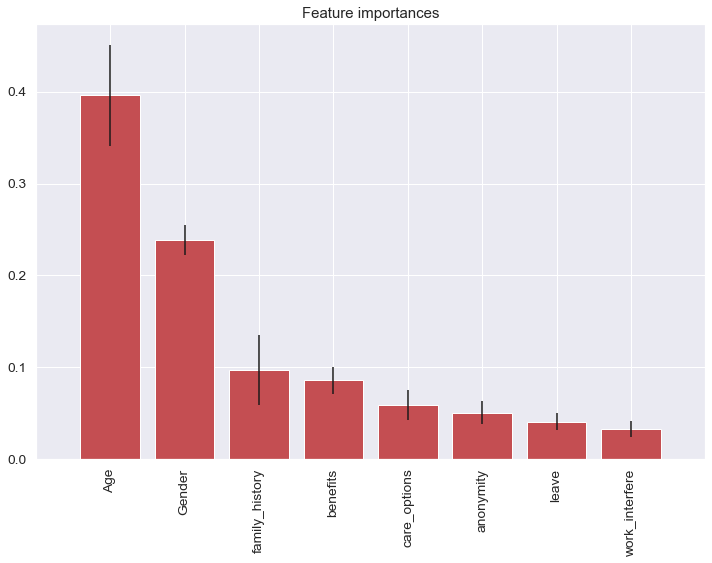

In [26]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [30]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    #Classification accuracy: percentage of correct predictions
    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy:\n', y_test.value_counts())
    
    # calculate the percentage of ones
    print('Percentage of ones:', y_test.mean())
    
    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean())
    
    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])
    
    #Conclusion:
    #Classification accuracy is the easiest classification metric to understand
    #But, it does not tell you the underlying distribution of response values
    #And, it does not tell you what "types" of errors your classifier is making
    
    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    #Metrics computed from a confusion matrix
    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    
    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    ##########################################
    #Adjusting the classification threshold
    ##########################################
    # print the first 10 predicted responses
    # 1D array (vector) of binary values (0, 1)
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])

    # print the first 10 predicted probabilities of class membership
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # print the first 10 predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]
    
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        # histogram of predicted probabilities
        # adjust the font size 
        plt.rcParams['font.size'] = 12
        # 8 bins
        plt.hist(y_pred_prob, bins=8)
        
        # x-axis limit from 0 to 1
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    
    
    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    # results are 2D so we slice out the first column
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])
    
    ##########################################
    #ROC Curves and Area Under the Curve (AUC)
    ##########################################
    
    #Question: Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?
    #Answer: Plot the ROC curve!
    
    
    #AUC is the percentage of the ROC plot that is underneath the curve
    #Higher value = better classifier
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    # we pass y_test and y_pred_prob
    # we do not use y_pred_class, because it will give incorrect results without generating an error
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # define a function that accepts a threshold and prints sensitivity and specificity
    def evaluate_threshold(threshold):
        #Sensitivity: When the actual value is positive, how often is the prediction correct?
        #Specificity: When the actual value is negative, how often is the prediction correct?print('Sensitivity for ' + str(threshold) + ' :', tpr[thresholds > threshold][-1])
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    # One way of setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
    
    
    
    return accuracy

In [31]:
##########################################
# Tuning with cross validation score
##########################################
def tuningCV(knn):
    
    # search for an optimal value of K for KNN
    k_range = list(range(1, 31))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())
    print(k_scores)
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()

In [32]:
def tuningGridSerach(knn):
    #More efficient parameter tuning using GridSearchCV
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    print(k_range)
    
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)
    
    # instantiate the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

    # fit the grid with data
    grid.fit(X, y)
    
    # view the complete results (list of named tuples)
    grid.grid_scores_
    
    # examine the first tuple
    print(grid.grid_scores_[0].parameters)
    print(grid.grid_scores_[0].cv_validation_scores)
    print(grid.grid_scores_[0].mean_validation_score)
    
    # create a list of the mean scores only
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    print(grid_mean_scores)
    
    # plot the results
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
    # examine the best model
    print('GridSearch best score', grid.best_score_)
    print('GridSearch best params', grid.best_params_)
    print('GridSearch best estimator', grid.best_estimator_)

In [33]:
def tuningRandomizedSearchCV(model, param_dist):
    #Searching multiple parameters simultaneously
    # n_iter controls the number of searches
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    rand.grid_scores_
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    print('Rand. Best Params: ', rand.best_params_)
    
    # run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)

In [34]:
def tuningMultParam(knn):
    
    #Searching multiple parameters simultaneously
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
        
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range, weights=weight_options)
    print(param_grid) 
    
    # instantiate and fit the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y) 
    
    # view the complete results
    print(grid.grid_scores_)
    
    # examine the best model
    print('Multiparam. Best Score: ', grid.best_score_)
    print('Multiparam. Best Params: ', grid.best_params_)

E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


########### Logistic Regression ###############
Accuracy: 0.798941798941799
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


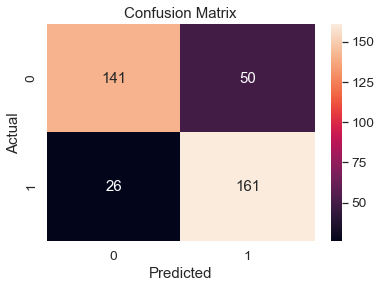

Classification Accuracy: 0.798941798941799
Classification Error: 0.20105820105820105
False Positive Rate: 0.2617801047120419
Precision: 0.7630331753554502
AUC Score: 0.799591231066439
Cross-validated AUC: 0.8753574228750638
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 0 1]
First 10 predicted probabilities of class members:
 [[0.09763161 0.90236839]
 [0.95330977 0.04669023]
 [0.96013985 0.03986015]
 [0.78441354 0.21558646]
 [0.37834349 0.62165651]
 [0.06235819 0.93764181]
 [0.74803691 0.25196309]
 [0.1743978  0.8256022 ]
 [0.61145489 0.38854511]
 [0.49232517 0.50767483]]
First 10 predicted probabilities:
 [[0.90236839]
 [0.04669023]
 [0.03986015]
 [0.21558646]
 [0.62165651]
 [0.93764181]
 [0.25196309]
 [0.8256022 ]
 [0.38854511]
 [0.50767483]]


E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\anaconda\lib\site-packages\sklea

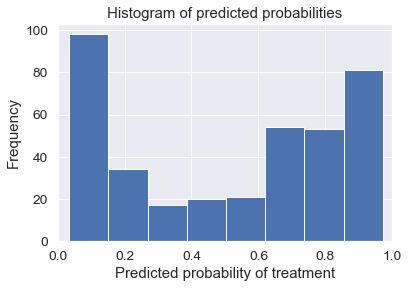

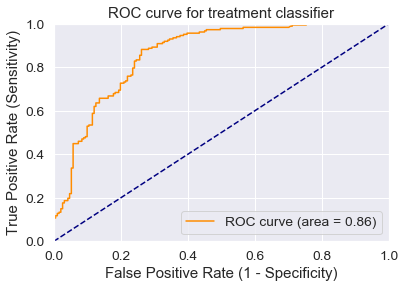

[[141  50]
 [ 26 161]]


In [35]:
def logisticRegression():
    # train a logistic regression model on the training set
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)
    
    print('########### Logistic Regression ###############')
    
    accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)
    
    #Data for final graph
    methodDict['Log. Regres.'] = accuracy_score * 100

logisticRegression()